In [1]:
# -*- coding: utf-8 -*-
# @author: tongzi
# @description: Learing best practices for model evaluation and hyperparameter tuning
# @created date: 2019/08/30
# @last modification: 2019/08/30

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**In this chapter, we will learn how to:  
(1) Obtain unbiased estimation of a model's performance  
(2) Diagnose the common problem of maching learning algorithms  
(3) Fine-tune machine learning models  
(4) Evaluate predictive models using different performance metrics**

### Loading the Breast Cancer Wisconsin dataset

In [3]:
df = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                header=None)

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# malignant (M) is represented as class 1, benign (B) is represented as class 0
le.transform(['M', 'B']) 

array([1, 0], dtype=int64)

In [8]:
from sklearn.cross_validation import train_test_split

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test =  \
train_test_split(X, y, test_size=0.2, random_state=1)

### Combining transformers and estimators in a pipeline

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [12]:
from sklearn.pipeline import Pipeline

In [13]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state=1))])

In [14]:
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [15]:
print(f'Test accuracy: {pipe_lr.score(X_test, y_test):.3f}')

Test accuracy: 0.947


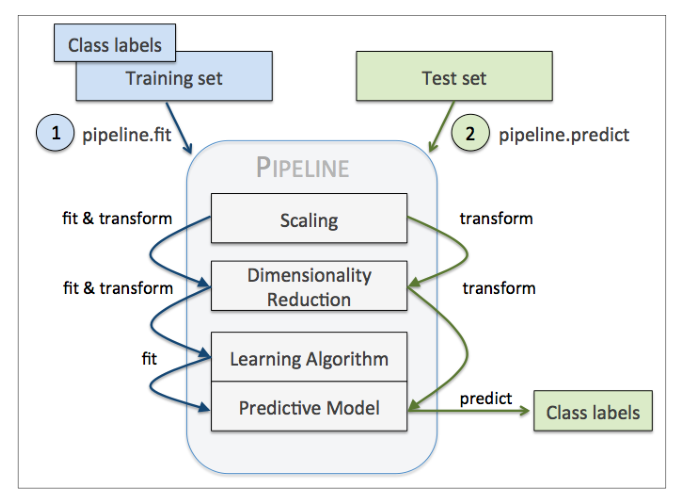

### Using k-fold cross-validation to assess model performance

In [16]:
from sklearn.model_selection import StratifiedKFold

In [17]:
kfold = StratifiedKFold(n_splits=10, random_state=1)

In [18]:
scores =[]
for k, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    pipe_lr.fit(X_train[train_index], y_train[train_index])
    score = pipe_lr.score(X_train[test_index], y_train[test_index])
    scores.append(score)
    print(f'Fold: {k+1}, Class dist: {np.bincount(y_train[train_index])}, Acc: {score:.3f}')

Fold: 1, Class dist: [256 153], Acc: 0.891
Fold: 2, Class dist: [256 153], Acc: 0.978
Fold: 3, Class dist: [256 153], Acc: 0.978
Fold: 4, Class dist: [256 153], Acc: 0.913
Fold: 5, Class dist: [256 153], Acc: 0.935
Fold: 6, Class dist: [257 153], Acc: 0.978
Fold: 7, Class dist: [257 153], Acc: 0.933
Fold: 8, Class dist: [257 153], Acc: 0.956
Fold: 9, Class dist: [257 153], Acc: 0.978
Fold: 10, Class dist: [257 153], Acc: 0.956


In [19]:
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.950 +/- 0.029


Although the previous code example was useful to illustrate how k-fold
cross-validation works, scikit-learn also implements a k-fold cross-validation
scorer, which allows us to evaluate our model using stratified k-fold
cross-validation more efficiently:

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)

In [22]:
print(f"cross-validation accuracy scores: {scores}")

cross-validation accuracy scores: [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]


In [23]:
print(f'cross-validation accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

cross-validation accuracy: 0.950 +/- 0.029


### Dignosing bias and variance problems with learning curves

In [24]:
from sklearn.learning_curve import learning_curve

C:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [25]:
from sklearn.model_selection import learning_curve

In [26]:
pipe_lr = Pipeline([('scl', StandardScaler()), 
                   ('clf', LogisticRegression(penalty='l2', random_state=0))])

In [27]:
train_sizes, train_scores, test_scores = \
learning_curve(estimator=pipe_lr, X=X_train, y=y_train,
              train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

In [28]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

(0.8, 1.0)

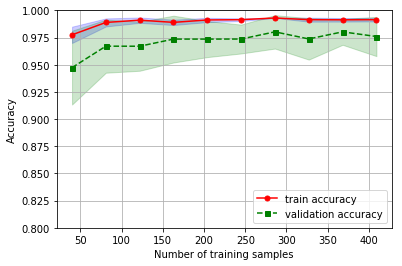

In [29]:
plt.plot(train_sizes, train_mean, color='red', marker='o', markersize=5, 
         label='train accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, 
         label='validation accuracy', linestyle='--')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                alpha=0.2, color='green')
plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])

### Addressing overfitting and underfitting with validation curves

In [30]:
from sklearn.model_selection import validation_curve

In [31]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = \
validation_curve(estimator=pipe_lr, X=X_train, y=y_train,
              param_name='clf__C', param_range=param_range, cv=10)

In [32]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

(0.8, 1.0)

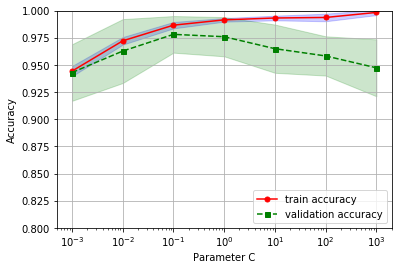

In [33]:
plt.plot(param_range, train_mean, color='red', marker='o', markersize=5, 
         label='train accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std,
                alpha=0.2, color='blue')

plt.plot(param_range, test_mean, color='green', marker='s', markersize=5, 
         label='validation accuracy', linestyle='--')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std,
                alpha=0.2, color='green')
plt.grid(True)
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])

### Fine-tuning machine learning via grid search  
In machine learing, we have two types of parameters: those that are learing from the training data, for example, the weights in logistic regression, and the parameters of a learning algorithm that is optimized separatly. The latter are the tuning parameters, also called hyperpatameters, of a model, for example, the **regularization** parameters in logistic regression or the **depth** parameter of a decision tree.

#### Tuning hyperparameter via grid search

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
from sklearn.svm import SVC

In [38]:
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(random_state=1))])

In [39]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

In [40]:
param_grid = [{'clf__C': param_range,
              'clf__kernel': ['linear']},
             {'clf__C': param_range,
             'clf__gamma': param_range,
             'clf__kernel': ['rbf']}]

In [41]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

In [42]:
gs = gs.fit(X_train, y_train)

In [43]:
print(gs.best_score_)

0.978021978021978


In [44]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


We will use the independent test dataset to estimate the best selected model, which is accessed via the ***best_estimator_*** attribute of the ***GridSearchCV*** object:

In [47]:
clf = gs.best_estimator_

In [48]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])

In [50]:
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.965


>Although ***grid_search*** is a powerful approach for finding the optimal set of parameters, the evaluation of all possible parameters combination is also computationally very expensive. An alternative approach to sampling different parameter combinations using scikit-learn is randomized search. Using the ***RandomizedSearchCV*** class in scikit-learn, we can draw random parameter combinations from sampling distribution with specified budget. More details and examples of its usage can be found at http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization.

### Algorithm selection with nested cross-validation

In [51]:
gs = GridSearchCV(estimator=pipe_svc, 
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

In [52]:
# 交叉验证分数
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)

In [54]:
print(f'Cross-Validation accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

Cross-Validation accuracy: 0.972 +/- 0.012


Use the nested cross-validation to approach to compare an SVM model to a simple decision tress classifier; for simplicity, we will only tune its ***depth*** parameter:

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy',
                 cv=5)

In [57]:
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

In [58]:
print(f'Cross-Validation accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

Cross-Validation accuracy: 0.908 +/- 0.045


### Looking at different performance evaluation metrics

#### Reading a confusion matrix  
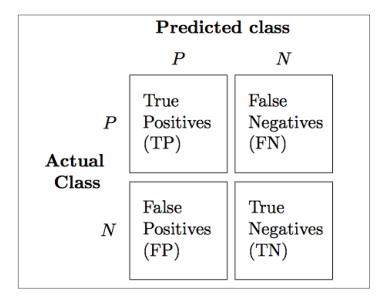

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
pipe_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])

In [61]:
y_pred = pipe_svc.predict(X_test)

In [62]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [63]:
print(confmat)

[[71  1]
 [ 2 40]]


The array that was returned after executing the preceding code provides us with information about the different types of errors the classifier made on the test dataset that we can map onto the confusion matrix illustration in the previous figure using ***matplotlib's matshow***() function:

Text(0,0.5,'actual label')

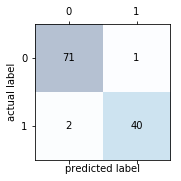

In [65]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('actual label')


#### Optimizing the precision and recall of a classification model  
$$ERR = \frac{FP+FN}{FP+FN+TP+TN}$$  
$$ACCC = \frac{TP+TN}{FP+FN+TP+TN} = 1 - ERR$$

In [67]:
from sklearn.metrics import precision_score

In [70]:
from sklearn.metrics import f1_score, recall_score

In [69]:
print(f'Precision: {precision_score(y_true=y_test, y_pred=y_pred):.3f}')

Precision: 0.976


In [72]:
print(f"Recall: {recall_score(y_true=y_test, y_pred=y_pred):.3f}")

Recall: 0.952


In [73]:
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_pred):.3f}')

F1-score: 0.964


Furthermore, we can use a different scoring metric other than accuracy in
GridSearch via the scoring parameter. A complete list of the different values that are accepted by the scoring parameter can be found at http://scikit-learn.org/ stable/modules/model_evaluation.html .

Remember that the positive class in scikit-learn is the class that is labeled as class 1. If we want to specify a different positive label, we can construct our own scorer via the make_scorer function, which we can then directly provide as an argument to the scoring parameter in GridSearchCV:

In [75]:
from sklearn.metrics import make_scorer, f1_score

In [76]:
scorer = make_scorer(f1_score, pos_label=0)

In [77]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, 
                  scoring=scorer, cv=10)

#### Plotting a receiver operating characteristic  
**Receiver operator characteristic (ROC)** graphs are useful tools for selecting models for classification based on their performance with respect to the false positive and true positive rates, which are computed by shifting the decision threshold of the classifier. The diagonal of an ROC graph can be interpreted as random guessing, and classification models that fall below the diagonal are considered as worse than random guessing. A perfect classifier would fall into the top-left corner of the graph with a true positive rate of 1 and a false positive rate of 0. Based on the ROC  curve, we can then compute the so-called **area under the curve (AUC)** to characterize the performance of a classification model.